# Cross-Subject EEG Comparison Analysis

This notebook processes multiple subjects' EEG data and performs cross-subject comparisons for meditation and alpha/theta ratio analysis.

## Objectives:
1. Process all subjects through the preprocessing pipeline
2. Extract standardized features (alpha power, theta power, Alpha/Theta ratio) for each subject
3. Compare subjects across experimental phases
4. Compare Rock vs Classical music conditions
5. Statistical analysis of group differences

## Important Notes:

**ICA Component Exclusion**: Before running the full analysis, you should:
1. Run the preprocessing pipeline for each subject individually (using `eeg-interpretation-demo.ipynb`)
2. Inspect ICA components for each subject
3. Identify artifact components (eye blinks, muscle activity, etc.)
4. Update the `ica_exclude_dict` in Section 3 with the component indices to exclude for each subject

Example:
```python
ica_exclude_dict = {
    'Rock_S_M_2025-12-15_16-11-41': [0, 1, 2],  # Exclude components 0, 1, 2
    'classical_A_M_2025-12-15_15-04-18': [1, 3],  # Exclude components 1, 3
    # ... add for each subject
}
```

If you don't set ICA exclusions, the pipeline will still run but may include artifacts in the analysis.

## 1. Import Libraries and Setup

In [2]:
import mne
import pandas as pd
import numpy as np
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import ttest_rel, ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Set style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Get the directory where this notebook is located
script_dir = Path.cwd()
data_dir = script_dir / "data"

print(f"Data directory: {data_dir}")
print(f"Data directory exists: {data_dir.exists()}")

Data directory: c:\Users\bicle\Desktop\project-eeg\EEG\eeg-project\data
Data directory exists: True


## 2. Define Subject Processing Function

This function processes a single subject through the complete preprocessing pipeline and extracts features.

In [3]:
def process_subject(vhdr_path, subject_id=None, music_condition=None, ica_exclude=None, verbose=False):
    """
    Process a single subject's EEG data through the preprocessing pipeline.
    
    Parameters:
    -----------
    vhdr_path : Path or str
        Path to the .vhdr file
    subject_id : str, optional
        Subject identifier (extracted from filename if not provided)
    music_condition : str, optional
        Music condition ('Rock' or 'Classical', extracted from filename if not provided)
    ica_exclude : list, optional
        List of ICA components to exclude (for manual ICA rejection)
    verbose : bool
        Whether to print progress messages
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'subject_id': Subject identifier
        - 'music_condition': Music condition
        - 'power_analysis_df': DataFrame with power analysis results
        - 'epochs_by_phase': Dictionary of epochs for each phase
        - 'success': Boolean indicating if processing was successful
        - 'error': Error message if processing failed
    """
    try:
        if verbose:
            print(f"\n{'='*60}")
            print(f"Processing: {vhdr_path.name}")
            print(f"{'='*60}")
        
        # Extract subject info from filename if not provided
        if subject_id is None or music_condition is None:
            filename = Path(vhdr_path).stem # type: ignore
            parts = filename.split('_')
            if music_condition is None:
                music_condition = parts[0]  # 'Rock' or 'classical'
            if subject_id is None:
                subject_id = '_'.join(parts[1:3]) if len(parts) > 2 else filename
        
        # Load data
        if verbose:
            print("Loading data...")
        raw_data = mne.io.read_raw_brainvision(vhdr_path, preload=True)
        
        # Preprocessing Pipeline
        if verbose:
            print("Applying notch filter (50, 100 Hz)...")
        raw_data_filtered = raw_data.copy().notch_filter(freqs=[50, 100])
        
        if verbose:
            print("Applying bandpass filter (1-40 Hz)...")
        raw_data_filtered = raw_data_filtered.filter(l_freq=1.0, h_freq=40.0)
        
        # ICA
        if verbose:
            print("Running ICA...")
        ica = ICA(n_components=0.99, random_state=97, max_iter='auto')
        ica.fit(raw_data_filtered)
        
        # Apply ICA exclusions if provided
        if ica_exclude is not None:
            ica.exclude = ica_exclude
            if verbose:
                print(f"Excluding ICA components: {ica_exclude}")
        
        # Apply ICA
        raw_data_clean = raw_data_filtered.copy()
        ica.apply(raw_data_clean)
        
        # Find protocol start (s1000 or s1050 as fallback)
        start_time = None
        
        # Try to find s1000 marker
        for onset, description in zip(raw_data_clean.annotations.onset, raw_data_clean.annotations.description):
            if 's1000' in str(description):
                start_time = onset
                break
        
        # If no s1000, try s1050 as fallback
        if start_time is None:
            for onset, description in zip(raw_data_clean.annotations.onset, raw_data_clean.annotations.description):
                if 's1050' in str(description):
                    start_time = onset
                    break
        
        if start_time is None:
            raise ValueError("No s1000 or s1050 marker found (protocol start)")
        
        protocol_start = start_time
        
        # Define phase durations (matching eeg-interpretation-demo.ipynb approach)
        base_phase_durations = [120, 120, 120, 60, 120, 60, 600]  # 7 phases
        post_task_duration = 120  # phase_8 duration
        
        # Calculate phase boundaries using numbered phases
        current_time = protocol_start
        recording_end = raw_data_clean.times[-1]
        phase_boundaries = {}
        
        # Create phase_1 through phase_7
        for i, duration in enumerate(base_phase_durations, start=1):
            phase_name = f"phase_{i}"
            phase_start = current_time
            phase_end = min(current_time + duration, recording_end)
            phase_boundaries[phase_name] = (phase_start, phase_end)
            current_time = phase_end
        
        # Check if we should add phase_8 (post_EC)
        # Only add if there's enough time remaining in the recording
        total_expected_duration = sum(base_phase_durations) + post_task_duration
        time_remaining = recording_end - protocol_start
        
        if time_remaining >= total_expected_duration - 10:  # Allow 10s tolerance
            phase_start = current_time
            phase_end = min(current_time + post_task_duration, recording_end)
            phase_boundaries["phase_8"] = (phase_start, phase_end)
        
        # Map numbered phases to descriptive names
        phase_name_mapping = {
            'phase_1': 'baseline_EO',
            'phase_2': 'baseline_EC',
            'phase_3': 'task_no_music',
            'phase_4': 'break1',
            'phase_5': 'task_music',
            'phase_6': 'break2',
            'phase_7': 'meditation',
            'phase_8': 'post_EC'
        }
        
        # Create epochs for each phase (matching eeg-interpretation-demo.ipynb approach)
        if verbose:
            print("Creating epochs...")
        epoch_duration = 30.0
        epoch_overlap = 0.0
        all_epochs_list = []
        all_metadata_list = []
        
        with mne.utils.use_log_level('ERROR'):
            for phase_num, (start, end) in phase_boundaries.items():
                phase_start = max(0.0, start)
                phase_end = min(end, recording_end)
                phase_length = phase_end - phase_start
                
                if phase_length <= 0:
                    continue
                
                try:
                    raw_phase = raw_data_clean.copy().crop(tmin=phase_start, tmax=phase_end)
                    epochs_phase = mne.make_fixed_length_epochs(
                        raw_phase,
                        duration=epoch_duration,
                        overlap=epoch_overlap,
                        preload=True
                    )
                    
                    n_epochs = len(epochs_phase)
                    phase_metadata = pd.DataFrame({
                        'phase': [phase_num] * n_epochs,
                        'epoch_in_phase': range(n_epochs)
                    })
                    epochs_phase.metadata = phase_metadata
                    
                    all_epochs_list.append(epochs_phase)
                    all_metadata_list.append(phase_metadata)
                except Exception as e:
                    if verbose:
                        print(f"  Warning: Could not create epochs for {phase_num}: {e}")
        
        # Concatenate all epochs
        if len(all_epochs_list) > 0:
            with mne.utils.use_log_level('ERROR'):
                combined_epochs = mne.concatenate_epochs(all_epochs_list)
            combined_epochs.metadata = pd.concat(all_metadata_list, ignore_index=True)
        else:
            raise ValueError("No epochs created")
        
        # Create epochs_by_phase dictionary with descriptive names for compatibility
        epochs_by_phase = {}
        for phase_num in combined_epochs.metadata['phase'].unique():
            phase_label = phase_name_mapping.get(phase_num, phase_num)
            epochs_by_phase[phase_label] = combined_epochs[combined_epochs.metadata['phase'] == phase_num]
        
        # Compute PSD for each phase
        if verbose:
            print("Computing power spectral density...")
        psd_by_phase = {}
        for phase_name, epochs_phase in epochs_by_phase.items():
            if epochs_phase is not None and len(epochs_phase) > 0:
                psd_by_phase[phase_name] = epochs_phase.compute_psd(
                    method='welch', fmin=1.0, fmax=40.0
                )
        
        # Extract theta and alpha power
        freq_bands = {'theta': (4, 8), 'alpha': (8, 13)}
        phase_power_results = {}
        
        for phase_name, psd_phase in psd_by_phase.items():
            theta_power = psd_phase.get_data(fmin=4, fmax=8).mean(axis=-1).mean(axis=0)
            alpha_power = psd_phase.get_data(fmin=8, fmax=13).mean(axis=-1).mean(axis=0)
            
            # Convert to µV²/Hz
            theta_power_µV = theta_power * 1e12
            alpha_power_µV = alpha_power * 1e12
            
            # Calculate Alpha/Theta ratio
            alpha_theta_ratio = alpha_power_µV / (theta_power_µV + 1e-12)  # Add small value to avoid division by zero
            
            phase_power_results[phase_name] = {
                'channels': psd_phase.ch_names,
                'theta': theta_power_µV,
                'alpha': alpha_power_µV,
                'alpha_theta_ratio': alpha_theta_ratio
            }
        
        # Create DataFrame
        results = []
        for phase_name, power_data in phase_power_results.items():
            for ch_idx, ch_name in enumerate(power_data['channels']):
                results.append({
                    'Subject': subject_id,
                    'Music_Condition': music_condition,
                    'Phase': phase_name,
                    'Channel': ch_name,
                    'Theta_Power_µV²': power_data['theta'][ch_idx],
                    'Alpha_Power_µV²': power_data['alpha'][ch_idx],
                    'Alpha_Theta_Ratio': power_data['alpha_theta_ratio'][ch_idx]
                })
        
        power_analysis_df = pd.DataFrame(results)
        
        if verbose:
            print(f"✓ Successfully processed {subject_id}")
            print(f"  Phases: {list(phase_power_results.keys())}")
            print(f"  Total rows: {len(power_analysis_df)}")
        
        return {
            'subject_id': subject_id,
            'music_condition': music_condition,
            'power_analysis_df': power_analysis_df,
            'epochs_by_phase': epochs_by_phase,
            'success': True,
            'error': None
        }
        
    except Exception as e:
        if verbose:
            print(f"✗ Error processing {vhdr_path.name}: {str(e)}")
        return {
            'subject_id': subject_id if subject_id else Path(vhdr_path).stem,
            'music_condition': music_condition,
            'power_analysis_df': None,
            'epochs_by_phase': None,
            'success': False,
            'error': str(e)
        }

## 3. Find All Data Files and Process Subjects

In [4]:
# Find all .vhdr files
vhdr_files = list(data_dir.glob("*.vhdr"))
print(f"Found {len(vhdr_files)} data files:")
for f in sorted(vhdr_files):
    print(f"  - {f.name}")

# Note: For now, we'll process without ICA exclusions
# In practice, you should inspect ICA components for each subject and set exclusions
# Example: ica_exclude_dict = {'subject1': [0, 1, 2], 'subject2': [1, 3], ...}
ica_exclude_dict = {}  # Add manual ICA exclusions here if needed

Found 6 data files:
  - classical_A_M_2025-12-15_15-04-18.vhdr
  - classical_A_S_2025-12-18_10-40-05.vhdr
  - classical_S_HA_2025-12-18_14-05-33.vhdr
  - Rock_B_A_2025-12-18_15-13-43.vhdr
  - Rock_S_H_2025-12-18_11-57-47.vhdr
  - Rock_S_M_2025-12-15_16-11-41.vhdr


In [5]:
# Process all subjects
all_results = []
failed_subjects = []

for vhdr_file in sorted(vhdr_files):
    subject_id = vhdr_file.stem
    ica_exclude = ica_exclude_dict.get(subject_id, None)
    
    result = process_subject(
        vhdr_file, 
        ica_exclude=ica_exclude,
        verbose=True
    )
    
    if result['success']:
        all_results.append(result)
    else:
        failed_subjects.append((subject_id, result['error']))

print(f"\n{'='*60}")
print(f"Processing Summary:")
print(f"  Successful: {len(all_results)}")
print(f"  Failed: {len(failed_subjects)}")
if failed_subjects:
    print(f"\nFailed subjects:")
    for subj, error in failed_subjects:
        print(f"  - {subj}: {error}")
print(f"{'='*60}")


Processing: classical_A_M_2025-12-15_15-04-18.vhdr
Loading data...
Extracting parameters from c:\Users\bicle\Desktop\project-eeg\EEG\eeg-project\data\classical_A_M_2025-12-15_15-04-18.vhdr...
Setting channel info structure...
Reading 0 ... 651019  =      0.000 ...  1302.038 secs...
Applying notch filter (50, 100 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)

Applying bandpass filter (1-40 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design 

## 4. Combine All Subjects' Data

In [6]:
# Combine all power analysis DataFrames
combined_df = pd.concat([r['power_analysis_df'] for r in all_results], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print(f"\nSubjects: {combined_df['Subject'].unique()}")
print(f"Music conditions: {combined_df['Music_Condition'].unique()}")
print(f"Phases: {combined_df['Phase'].unique()}")
print(f"\nFirst few rows:")
combined_df.head(10)

Combined dataset shape: (1012, 7)

Subjects: ['A_M' 'A_S' 'S_HA' 'B_A' 'S_H' 'S_M']
Music conditions: ['classical' 'Rock']
Phases: ['baseline_EO' 'baseline_EC' 'task_no_music' 'break1' 'task_music'
 'break2' 'meditation' 'post_EC']

First few rows:


,Subject,Music_Condition,Phase,Channel,Theta_Power_µV²,Alpha_Power_µV²,Alpha_Theta_Ratio
0,A_M,classical,baseline_EO,FPz,3.275210,3.748564,1.144526
1,A_M,classical,baseline_EO,FCz,1.643861,2.822857,1.717211
2,A_M,classical,baseline_EO,F9,3.110874,3.992735,1.283477
3,A_M,classical,baseline_EO,F3,1.939114,2.609330,1.345630
4,A_M,classical,baseline_EO,F4,2.142671,3.071040,1.433276
5,A_M,classical,baseline_EO,F10,3.400683,4.245616,1.248460
6,A_M,classical,baseline_EO,Cz,0.847798,1.775144,2.093830
7,A_M,classical,baseline_EO,M1,3.030467,4.961065,1.637063
8,A_M,classical,baseline_EO,T7,5.428291,19.733777,3.635357
9,A_M,classical,baseline_EO,C3,0.923012,1.538601,1.666935


## 5. Aggregate Data for Cross-Subject Analysis

We'll aggregate data by averaging across channels to get subject-level metrics for each phase.

In [7]:
# Aggregate by subject and phase (average across channels)
subject_phase_summary = combined_df.groupby(['Subject', 'Music_Condition', 'Phase']).agg({
    'Theta_Power_µV²': ['mean', 'std'],
    'Alpha_Power_µV²': ['mean', 'std'],
    'Alpha_Theta_Ratio': ['mean', 'std']
}).reset_index()

# Flatten column names
subject_phase_summary.columns = [
    'Subject', 'Music_Condition', 'Phase',
    'Theta_Mean', 'Theta_Std',
    'Alpha_Mean', 'Alpha_Std',
    'Alpha_Theta_Mean', 'Alpha_Theta_Std'
]

# Define chronological phase order
phase_order = ['baseline_EO', 'baseline_EC', 'task_no_music', 'break1', 
               'task_music', 'break2', 'meditation', 'post_EC']

# Convert Phase column to categorical with chronological order
# This ensures x-axis shows phases in chronological order rather than alphabetical
subject_phase_summary['Phase'] = pd.Categorical(
    subject_phase_summary['Phase'], 
    categories=phase_order, 
    ordered=True
)

print("Subject-Phase Summary:")
print(f"Shape: {subject_phase_summary.shape}")
print(f"\nFirst few rows:")
subject_phase_summary.head(10)

Subject-Phase Summary:
Shape: (46, 9)

First few rows:


,Subject,Music_Condition,Phase,Theta_Mean,Theta_Std,Alpha_Mean,Alpha_Std,Alpha_Theta_Mean,Alpha_Theta_Std
0,A_M,classical,baseline_EC,2.653534,1.301376,3.699478,2.875532,1.368890,0.484777
1,A_M,classical,baseline_EO,2.338636,1.199867,4.580315,3.817710,1.923430,0.565811
2,A_M,classical,break1,2.651704,1.205850,3.436591,1.645574,1.335893,0.278297
3,A_M,classical,break2,3.135741,1.836251,3.372481,4.089865,1.023544,0.471873
4,A_M,classical,meditation,2.524032,1.156327,2.857805,1.415551,1.168632,0.261568
5,A_M,classical,task_music,3.364723,2.969691,3.015162,1.902799,1.102080,0.462186
6,A_M,classical,task_no_music,2.280251,1.073295,2.842221,1.768243,1.262953,0.420700
7,A_S,classical,baseline_EC,6.886934,3.259668,48.362047,18.789438,7.710565,2.244972
8,A_S,classical,baseline_EO,4.700925,4.674902,19.409934,11.599773,6.057828,3.910251
9,A_S,classical,break1,4.531183,2.574803,39.622028,19.758267,10.247947,4.682950


## 6. Visualizations: Cross-Subject Comparisons

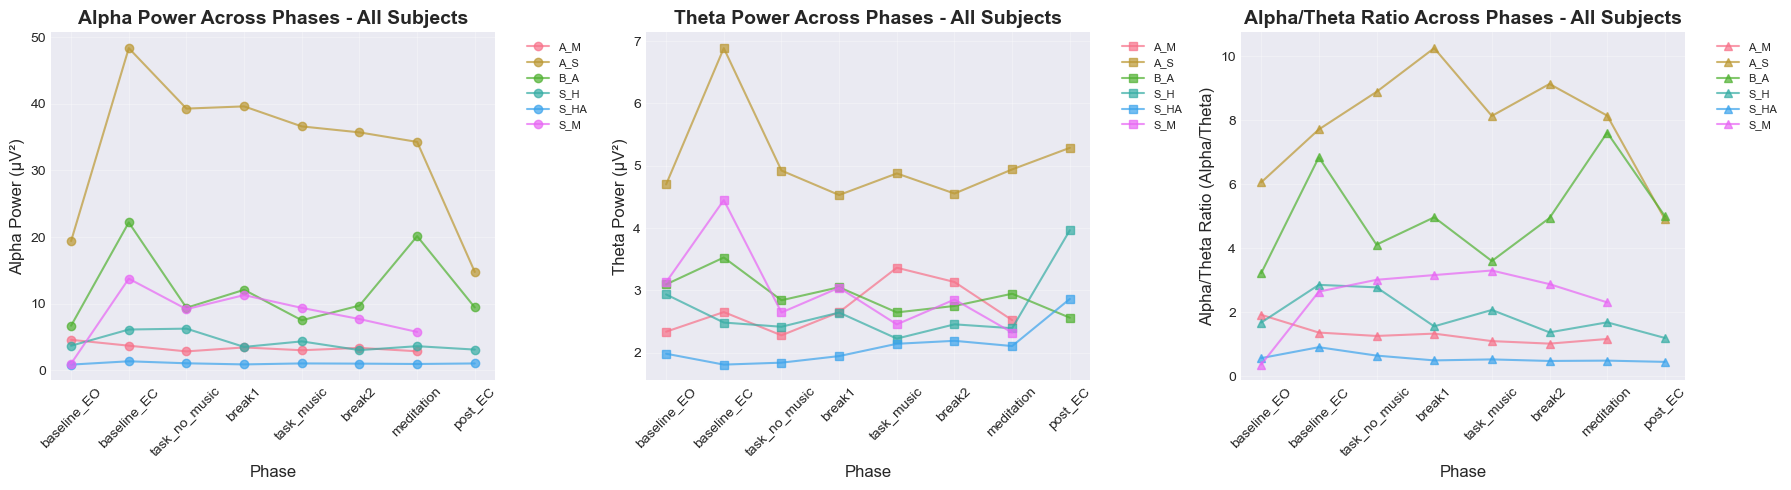

In [8]:
# 6.1: Alpha Power by Phase - All Subjects
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Alpha Power
ax = axes[0]
for subject in subject_phase_summary['Subject'].unique():
    subj_data = subject_phase_summary[subject_phase_summary['Subject'] == subject].sort_values('Phase')
    ax.plot(subj_data['Phase'], subj_data['Alpha_Mean'], marker='o', label=subject, alpha=0.7)

ax.set_xlabel('Phase', fontsize=12)
ax.set_ylabel('Alpha Power (µV²)', fontsize=12)
ax.set_title('Alpha Power Across Phases - All Subjects', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Theta Power
ax = axes[1]
for subject in subject_phase_summary['Subject'].unique():
    subj_data = subject_phase_summary[subject_phase_summary['Subject'] == subject].sort_values('Phase')
    ax.plot(subj_data['Phase'], subj_data['Theta_Mean'], marker='s', label=subject, alpha=0.7)

ax.set_xlabel('Phase', fontsize=12)
ax.set_ylabel('Theta Power (µV²)', fontsize=12)
ax.set_title('Theta Power Across Phases - All Subjects', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Alpha/Theta Ratio
ax = axes[2]
for subject in subject_phase_summary['Subject'].unique():
    subj_data = subject_phase_summary[subject_phase_summary['Subject'] == subject].sort_values('Phase')
    ax.plot(subj_data['Phase'], subj_data['Alpha_Theta_Mean'], marker='^', label=subject, alpha=0.7)

ax.set_xlabel('Phase', fontsize=12)
ax.set_ylabel('Alpha/Theta Ratio (Alpha/Theta)', fontsize=12)
ax.set_title('Alpha/Theta Ratio Across Phases - All Subjects', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interpretation: Individual Subject Trends
The plots above display the dynamic changes in Alpha and Theta power, as well as the Alpha/Theta ratio, for each individual subject across the experimental phases.
*   **Alpha Blocking**: Expect to see lower Alpha power in "baseline_EO" compared to "baseline_EC", demonstrating the classic alpha blocking effect.
*   **Meditation**: Observe if there is a distinct shift in Alpha or Theta power during the "meditation" phase compared to the "task" phases.
*   **Individual Variability**: Note the significant spread between subjects, highlighting the importance of using iAF (Individual Alpha Frequency) and within-subject comparisons.

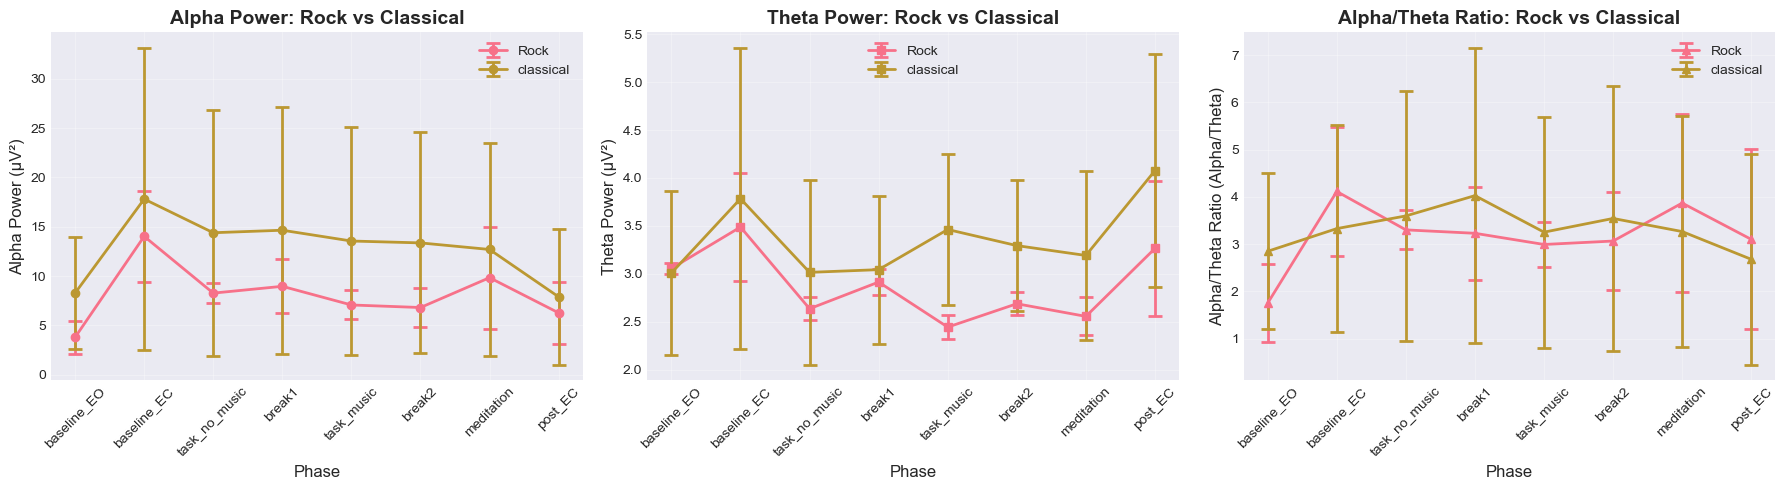

In [9]:
# 6.2: Group Comparison - Rock vs Classical
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Group by music condition
grouped = subject_phase_summary.groupby(['Music_Condition', 'Phase']).agg({
    'Alpha_Mean': ['mean', 'sem'],
    'Theta_Mean': ['mean', 'sem'],
    'Alpha_Theta_Mean': ['mean', 'sem']
}).reset_index()

grouped.columns = ['Music_Condition', 'Phase', 'Alpha_Mean', 'Alpha_SEM', 
                   'Theta_Mean', 'Theta_SEM', 'Alpha_Theta_Mean', 'Alpha_Theta_SEM']

# Ensure Phase column maintains chronological order
phase_order = ['baseline_EO', 'baseline_EC', 'task_no_music', 'break1', 
               'task_music', 'break2', 'meditation', 'post_EC']
grouped['Phase'] = pd.Categorical(
    grouped['Phase'], 
    categories=phase_order, 
    ordered=True
)

# Alpha Power
ax = axes[0]
for condition in ['Rock', 'classical']:
    cond_data = grouped[grouped['Music_Condition'] == condition].sort_values('Phase')
    if len(cond_data) > 0:
        ax.errorbar(cond_data['Phase'], cond_data['Alpha_Mean'], 
                   yerr=cond_data['Alpha_SEM'], marker='o', label=condition, 
                   capsize=5, capthick=2, linewidth=2)

ax.set_xlabel('Phase', fontsize=12)
ax.set_ylabel('Alpha Power (µV²)', fontsize=12)
ax.set_title('Alpha Power: Rock vs Classical', fontsize=14, fontweight='bold')
ax.legend()
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Theta Power
ax = axes[1]
for condition in ['Rock', 'classical']:
    cond_data = grouped[grouped['Music_Condition'] == condition].sort_values('Phase')
    if len(cond_data) > 0:
        ax.errorbar(cond_data['Phase'], cond_data['Theta_Mean'], 
                   yerr=cond_data['Theta_SEM'], marker='s', label=condition, 
                   capsize=5, capthick=2, linewidth=2)

ax.set_xlabel('Phase', fontsize=12)
ax.set_ylabel('Theta Power (µV²)', fontsize=12)
ax.set_title('Theta Power: Rock vs Classical', fontsize=14, fontweight='bold')
ax.legend()
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Alpha/Theta Ratio
ax = axes[2]
for condition in ['Rock', 'classical']:
    cond_data = grouped[grouped['Music_Condition'] == condition].sort_values('Phase')
    if len(cond_data) > 0:
        ax.errorbar(cond_data['Phase'], cond_data['Alpha_Theta_Mean'], 
                   yerr=cond_data['Alpha_Theta_SEM'], marker='^', label=condition, 
                   capsize=5, capthick=2, linewidth=2)

ax.set_xlabel('Phase', fontsize=12)
ax.set_ylabel('Alpha/Theta Ratio (Alpha/Theta)', fontsize=12)
ax.set_title('Alpha/Theta Ratio: Rock vs Classical', fontsize=14, fontweight='bold')
ax.legend()
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interpretation: Rock vs. Classical Group Comparison
These plots compare the group means (with Standard Error of the Mean) for subjects listening to Rock versus Classical music.
*   **Condition Effects**: Determine if one music genre elicits consistently higher Alpha or Theta power during the "task_music" phase.
*   **Recovery**: Check the "break2" and "meditation" phases to see if the physiological recovery differs between the two groups.
*   **Trend Consistency**: Verify if both groups follow similar physiological patterns (e.g., EO < EC) despite amplitude differences.

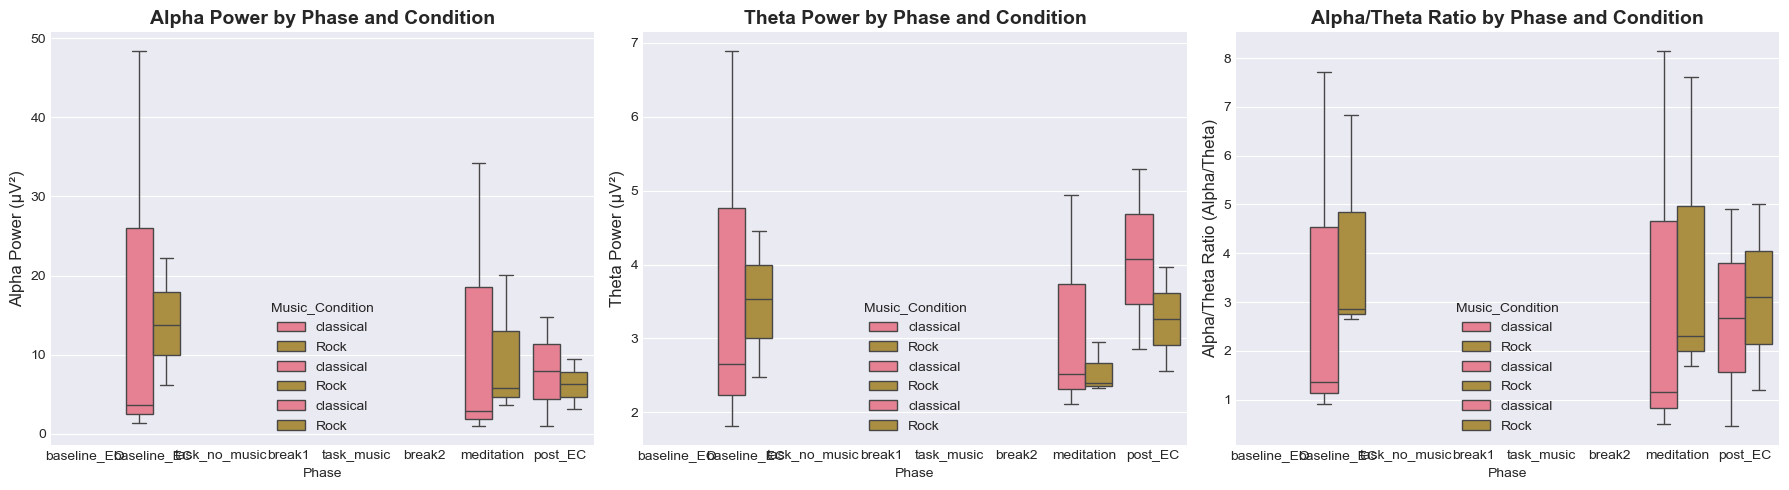

In [10]:
# 6.3: Box plots comparing key phases
key_phases = ['baseline_EC', 'meditation', 'post_EC']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, phase in enumerate(key_phases):
    phase_data = subject_phase_summary[subject_phase_summary['Phase'] == phase]
    
    if len(phase_data) > 0:
        # Alpha Power
        ax = axes[0]
        sns.boxplot(data=phase_data, x='Phase', y='Alpha_Mean', hue='Music_Condition', ax=ax)
        ax.set_title('Alpha Power by Phase and Condition', fontsize=14, fontweight='bold')
        ax.set_ylabel('Alpha Power (µV²)', fontsize=12)
        
        # Theta Power
        ax = axes[1]
        sns.boxplot(data=phase_data, x='Phase', y='Theta_Mean', hue='Music_Condition', ax=ax)
        ax.set_title('Theta Power by Phase and Condition', fontsize=14, fontweight='bold')
        ax.set_ylabel('Theta Power (µV²)', fontsize=12)
        
        # Alpha/Theta Ratio
        ax = axes[2]
        sns.boxplot(data=phase_data, x='Phase', y='Alpha_Theta_Mean', hue='Music_Condition', ax=ax)
        ax.set_title('Alpha/Theta Ratio by Phase and Condition', fontsize=14, fontweight='bold')
        ax.set_ylabel('Alpha/Theta Ratio (Alpha/Theta)', fontsize=12)

plt.tight_layout()
plt.show()

### Interpretation: Key Phase Distributions
The box plots focus on the distribution of brain activity during the three most critical resting states: Baseline EC, Meditation, and Post-Meditation EC.
*   **Meditation State**: Compare the median power during "meditation" versus "baseline_EC". An increase in Alpha or Theta is often associated with a meditative state.
*   **Post-Meditation Effects**: Analyze if the "post_EC" phase retains any elevated power levels observed during meditation, suggesting a lingering effect.
*   **Group Outliers**: Identify any subjects that deviate significantly from the group distribution in these key phases.

Using pyvistaqt 3d backend.
Effective window size : 4.096 (s)


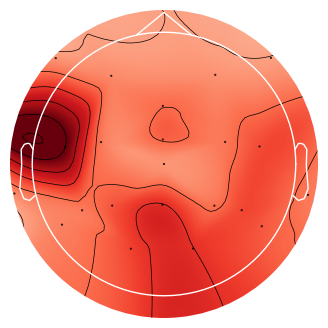

Effective window size : 4.096 (s)


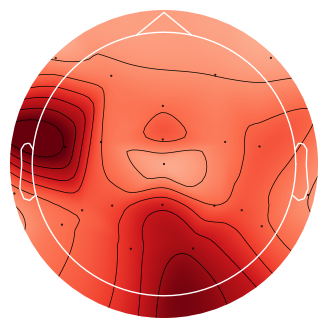

Effective window size : 4.096 (s)


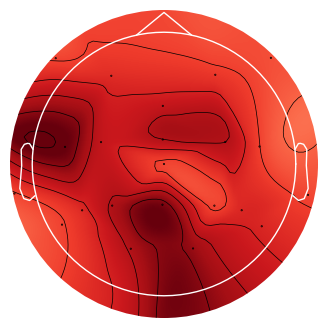

Effective window size : 4.096 (s)


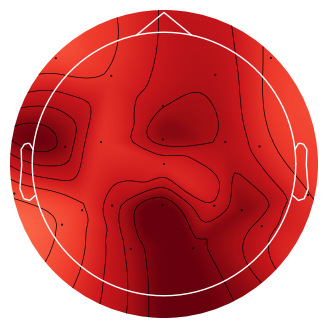

Effective window size : 4.096 (s)


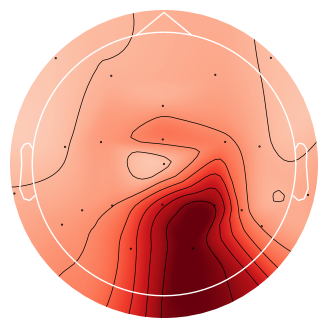

Effective window size : 4.096 (s)


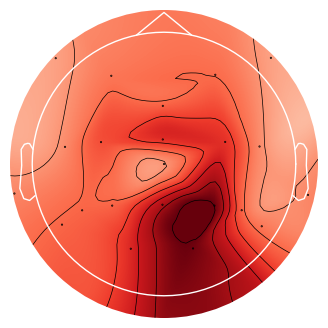

Effective window size : 4.096 (s)


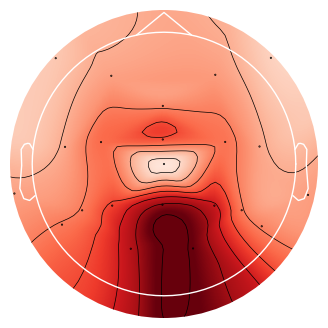

Effective window size : 4.096 (s)


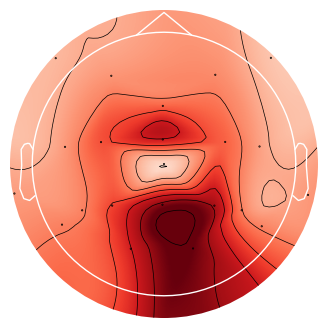

Effective window size : 4.096 (s)


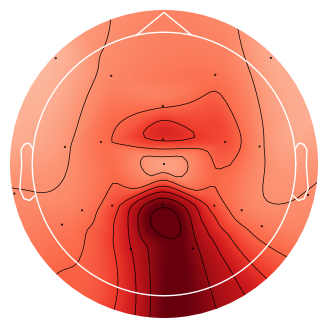

Effective window size : 4.096 (s)


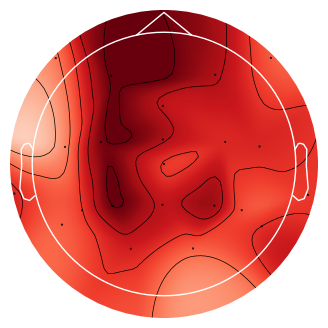

Effective window size : 4.096 (s)


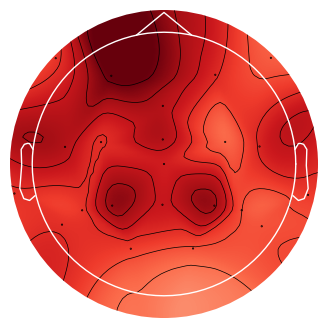

Effective window size : 4.096 (s)


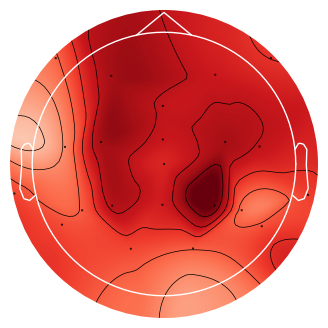

Effective window size : 4.096 (s)


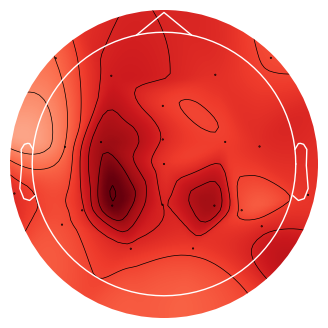

Effective window size : 4.096 (s)


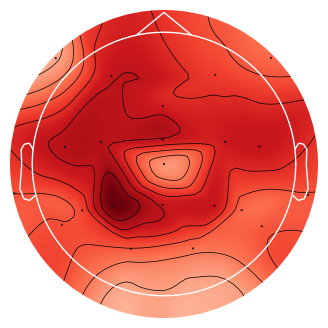

Effective window size : 4.096 (s)


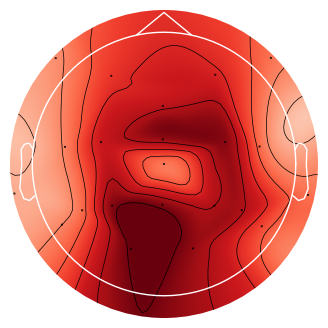

Effective window size : 4.096 (s)


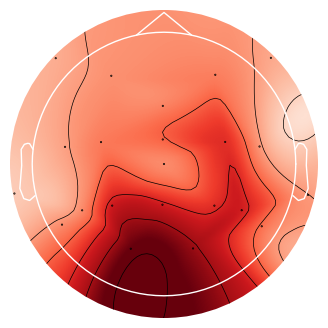

Effective window size : 4.096 (s)


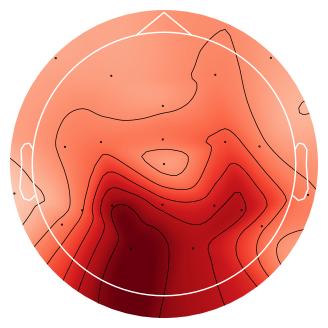

Effective window size : 4.096 (s)


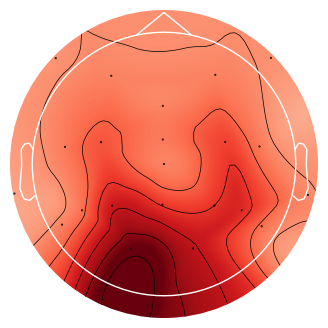

Effective window size : 4.096 (s)


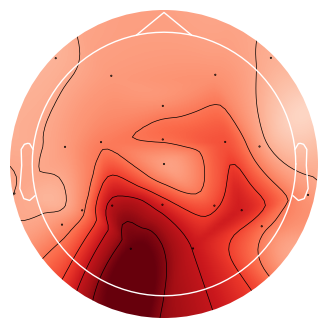

Effective window size : 4.096 (s)


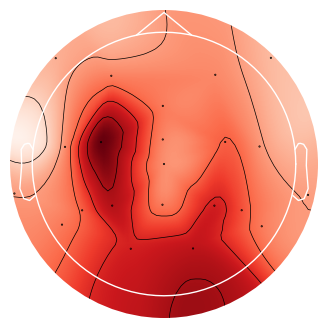

Effective window size : 4.096 (s)


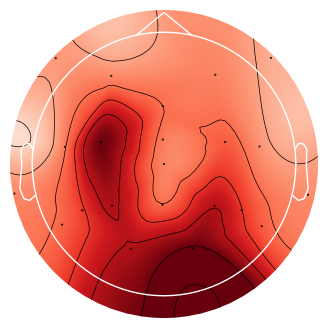

Effective window size : 4.096 (s)


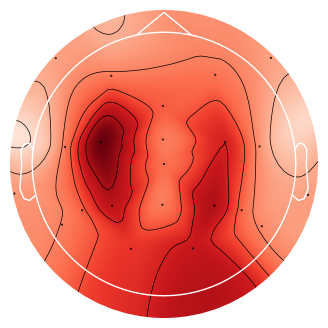

Effective window size : 4.096 (s)


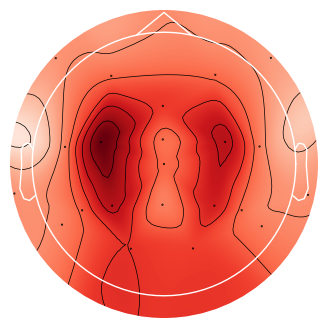

Effective window size : 4.096 (s)


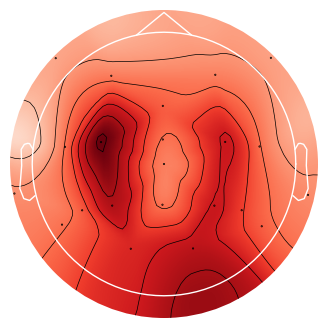

Effective window size : 4.096 (s)


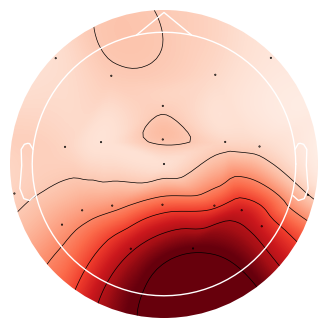

Effective window size : 4.096 (s)


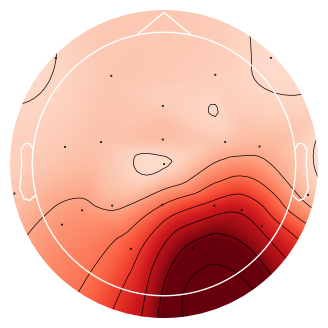

Effective window size : 4.096 (s)


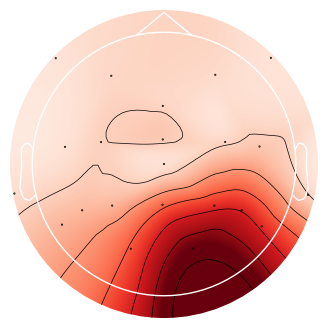

Effective window size : 4.096 (s)


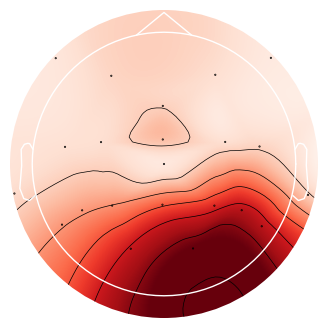

Effective window size : 4.096 (s)


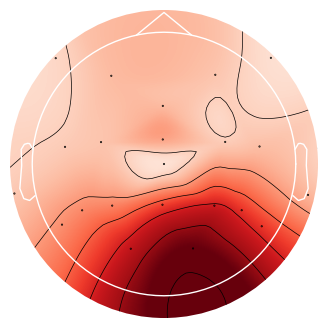

Meditation Segments (2-min) summary:
  Subject Music_Condition  Segment Channel  Alpha_Power_µV²  Theta_Power_µV²  \
0     A_M       classical  00-120s     FPz         2.844212         3.226642   
1     A_M       classical  00-120s     FCz         1.666149         1.399346   
2     A_M       classical  00-120s      F9         3.038146         3.358100   
3     A_M       classical  00-120s      F3         1.894352         1.944741   
4     A_M       classical  00-120s      F4         1.941167         2.135250   
5     A_M       classical  00-120s     F10         2.947091         3.648691   
6     A_M       classical  00-120s      Cz         0.983208         0.800421   
7     A_M       classical  00-120s      M1         3.460880         3.415339   
8     A_M       classical  00-120s      T7         9.751423         4.044761   
9     A_M       classical  00-120s      C3         0.955310         0.881119   

   Alpha_Theta_Ratio  
0           0.881477  
1           1.190663  
2           0

,Subject,Music_Condition,Segment,Alpha_Power_µV²,Theta_Power_µV²,Alpha_Theta_Ratio
0,A_M,classical,00-120s,2.867258,2.319391,1.231266
1,A_M,classical,120-240s,3.000691,2.427981,1.247846
2,A_M,classical,240-360s,3.053132,3.016481,1.056628
3,A_M,classical,360-480s,2.656625,2.258233,1.222789
4,A_S,classical,00-120s,26.708658,3.785690,7.903990
5,A_S,classical,120-240s,33.677346,4.237210,8.813282
6,A_S,classical,240-360s,35.131403,5.700510,7.959844
7,A_S,classical,360-480s,39.067441,5.769189,8.434624
8,A_S,classical,480-600s,36.858488,5.218149,7.967471
9,B_A,Rock,00-120s,24.300780,3.907416,7.235933


In [17]:
segment_seconds = 120
segment_rows = []

# Toggle to avoid lots of figures
segment_plots = True

# Ensure 3D viewer opens in a GUI window (MNE app)
mne.viz.set_3d_backend('pyvistaqt')

def _plot_meditation_segment_3d(values, info, title):
    """
    Open 3D topomap in the MNE app window; fall back to 2D if 3D isn't available.
    """
    try:
        from mne.viz import plot_3d_topomap
        fig = plot_3d_topomap(values, info, ch_type='eeg', show=True)
        fig.suptitle(title)
    except Exception:
        fig, ax = plt.subplots(figsize=(4, 4))
        mne.viz.plot_topomap(values, info, axes=ax, show=True)
        ax.set_title(title)

for result in all_results:
    epochs_med = result['epochs_by_phase'].get('meditation') if result['epochs_by_phase'] else None
    if epochs_med is None or len(epochs_med) == 0:
        continue

    # Ensure EEG-only for clean topomaps
    epochs_med = epochs_med.copy().pick('eeg')

    # Attach standard montage if missing digitization points
    try:
        if len(epochs_med.info['dig']) == 0:
            epochs_med.set_montage('standard_1020', on_missing='ignore')
    except Exception:
        epochs_med.set_montage('standard_1020', on_missing='ignore')

    # Derive epoch duration (seconds)
    epoch_duration = epochs_med.tmax - epochs_med.tmin
    if epoch_duration <= 0:
        continue

    # Number of epochs per 2-minute segment
    epochs_per_segment = int(round(segment_seconds / epoch_duration))
    epochs_per_segment = max(1, epochs_per_segment)

    # Full segments only
    n_segments = len(epochs_med) // epochs_per_segment

    for seg_idx in range(n_segments):
        seg_start = seg_idx * epochs_per_segment
        seg_end = (seg_idx + 1) * epochs_per_segment
        seg_epochs = epochs_med[seg_start:seg_end]

        # PSD per segment
        psd = seg_epochs.compute_psd(method='welch', fmin=1.0, fmax=40.0)

        theta = psd.get_data(fmin=4, fmax=8).mean(axis=-1).mean(axis=0)
        alpha = psd.get_data(fmin=8, fmax=13).mean(axis=-1).mean(axis=0)

        theta_uV = theta * 1e12
        alpha_uV = alpha * 1e12
        ratio = alpha_uV / (theta_uV + 1e-12)

        seg_label = f"{seg_idx * segment_seconds:02d}-{(seg_idx + 1) * segment_seconds:02d}s"

        # Store per-channel stats
        for ch, a, t, r in zip(seg_epochs.ch_names, alpha_uV, theta_uV, ratio):
            segment_rows.append({
                'Subject': result['subject_id'],
                'Music_Condition': result['music_condition'],
                'Segment': seg_label,
                'Channel': ch,
                'Alpha_Power_µV²': a,
                'Theta_Power_µV²': t,
                'Alpha_Theta_Ratio': r
            })

        # 3D regional activity visualization (Alpha/Theta Ratio)
        if segment_plots:
            _plot_meditation_segment_3d(
                ratio,
                seg_epochs.info,
                f"{result['subject_id']} meditation {seg_label}: Alpha/Theta"
            )

meditation_segments_df = pd.DataFrame(segment_rows)
print("Meditation Segments (2-min) summary:")
print(meditation_segments_df.head(10))

# Optional: subject-level segment summary (mean across channels)
segment_summary = meditation_segments_df.groupby(
    ['Subject', 'Music_Condition', 'Segment']
).agg({
    'Alpha_Power_µV²': 'mean',
    'Theta_Power_µV²': 'mean',
    'Alpha_Theta_Ratio': 'mean'
}).reset_index()

segment_summary.head(10)

## 7. Statistical Analysis

In [ ]:
# 7.1: Within-subject comparison: Baseline vs Meditation vs Post-meditation
key_phases = ['baseline_EC', 'meditation', 'post_EC']

print("="*60)
print("WITHIN-SUBJECT COMPARISONS")
print("="*60)

for phase in key_phases:
    phase_data = subject_phase_summary[subject_phase_summary['Phase'] == phase]
    print(f"\n{phase.upper()}:")
    print(f"  N subjects: {len(phase_data)}")
    print(f"  Alpha Power: {phase_data['Alpha_Mean'].mean():.2f} ± {phase_data['Alpha_Mean'].std():.2f} µV²")
    print(f"  Theta Power: {phase_data['Theta_Mean'].mean():.2f} ± {phase_data['Theta_Mean'].std():.2f} µV²")
    print(f"  Alpha/Theta Ratio: {phase_data['Alpha_Theta_Mean'].mean():.2f} ± {phase_data['Alpha_Theta_Mean'].std():.2f}")

# Paired comparisons (if we have the same subjects across phases)
baseline_data = subject_phase_summary[subject_phase_summary['Phase'] == 'baseline_EC']
meditation_data = subject_phase_summary[subject_phase_summary['Phase'] == 'meditation']
post_data = subject_phase_summary[subject_phase_summary['Phase'] == 'post_EC']

# Merge to get paired data
paired_baseline_med = pd.merge(baseline_data[['Subject', 'Alpha_Mean', 'Theta_Mean', 'Alpha_Theta_Mean']], 
                               meditation_data[['Subject', 'Alpha_Mean', 'Theta_Mean', 'Alpha_Theta_Mean']], 
                               on='Subject', suffixes=('_baseline', '_meditation'))

paired_med_post = pd.merge(meditation_data[['Subject', 'Alpha_Mean', 'Theta_Mean', 'Alpha_Theta_Mean']], 
                           post_data[['Subject', 'Alpha_Mean', 'Theta_Mean', 'Alpha_Theta_Mean']], 
                           on='Subject', suffixes=('_meditation', '_post'))

print("\n" + "="*60)
print("PAIRED T-TESTS (Baseline vs Meditation)")
print("="*60)
print(f"\nNote: Sample size n={len(paired_baseline_med)}. Low sample size reduces statistical power.")
print("Effect sizes and confidence intervals are reported to better assess practical significance.\n")

# Helper function to calculate Cohen's d for paired samples
def cohens_d_paired(x, y):
    """Calculate Cohen's d for paired samples"""
    diff = x - y
    d = diff.mean() / diff.std()
    return d

# Helper function to calculate 95% CI for mean difference
def mean_diff_ci(x, y, confidence=0.95):
    """Calculate confidence interval for mean difference in paired samples"""
    diff = x - y
    mean_diff = diff.mean()
    sem = stats.sem(diff)
    dof = len(diff) - 1
    t_crit = stats.t.ppf((1 + confidence) / 2, dof)
    ci_lower = mean_diff - t_crit * sem
    ci_upper = mean_diff + t_crit * sem
    return mean_diff, ci_lower, ci_upper

if len(paired_baseline_med) > 1:
    # Alpha Power
    baseline_alpha = paired_baseline_med['Alpha_Mean_baseline']
    med_alpha = paired_baseline_med['Alpha_Mean_meditation']
    t_stat, p_val = ttest_rel(baseline_alpha, med_alpha)
    cohens_d = cohens_d_paired(baseline_alpha, med_alpha)
    mean_diff, ci_lower, ci_upper = mean_diff_ci(baseline_alpha, med_alpha)
    
    print(f"\nAlpha Power (Baseline vs Meditation):")
    print(f"  N pairs: {len(paired_baseline_med)}")
    print(f"  Baseline: {baseline_alpha.mean():.2f} ± {baseline_alpha.std():.2f} µV²")
    print(f"  Meditation: {med_alpha.mean():.2f} ± {med_alpha.std():.2f} µV²")
    print(f"  Mean difference: {mean_diff:.2f} µV² [95% CI: {ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"  t-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")
    print(f"  Cohen's d (effect size): {cohens_d:.3f} ({'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'} effect)")
    
    # Theta Power
    baseline_theta = paired_baseline_med['Theta_Mean_baseline']
    med_theta = paired_baseline_med['Theta_Mean_meditation']
    t_stat, p_val = ttest_rel(baseline_theta, med_theta)
    cohens_d = cohens_d_paired(baseline_theta, med_theta)
    mean_diff, ci_lower, ci_upper = mean_diff_ci(baseline_theta, med_theta)
    
    print(f"\nTheta Power (Baseline vs Meditation):")
    print(f"  N pairs: {len(paired_baseline_med)}")
    print(f"  Baseline: {baseline_theta.mean():.2f} ± {baseline_theta.std():.2f} µV²")
    print(f"  Meditation: {med_theta.mean():.2f} ± {med_theta.std():.2f} µV²")
    print(f"  Mean difference: {mean_diff:.2f} µV² [95% CI: {ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"  t-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")
    print(f"  Cohen's d (effect size): {cohens_d:.3f} ({'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'} effect)")
    
    # Alpha/Theta Ratio
    baseline_ratio = paired_baseline_med['Alpha_Theta_Mean_baseline']
    med_ratio = paired_baseline_med['Alpha_Theta_Mean_meditation']
    t_stat, p_val = ttest_rel(baseline_ratio, med_ratio)
    cohens_d = cohens_d_paired(baseline_ratio, med_ratio)
    mean_diff, ci_lower, ci_upper = mean_diff_ci(baseline_ratio, med_ratio)
    
    print(f"\nAlpha/Theta Ratio (Baseline vs Meditation):")
    print(f"  N pairs: {len(paired_baseline_med)}")
    print(f"  Baseline: {baseline_ratio.mean():.2f} ± {baseline_ratio.std():.2f}")
    print(f"  Meditation: {med_ratio.mean():.2f} ± {med_ratio.std():.2f}")
    print(f"  Mean difference: {mean_diff:.2f} [95% CI: {ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"  t-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")
    print(f"  Cohen's d (effect size): {cohens_d:.3f} ({'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'} effect)")
    
    print(f"\n{'='*60}")
    print("INTERPRETATION:")
    print(f"{'='*60}")
    print("With n=6, statistical power is low (~30-50% for medium effects).")
    print("High variance in the data also reduces power to detect true differences.")
    print("Focus on effect sizes and confidence intervals, not just p-values.")
    if abs(cohens_d_paired(baseline_alpha, med_alpha)) > 0.5 or abs(cohens_d_paired(baseline_theta, med_theta)) > 0.5:
        print("Medium-to-large effect sizes suggest potentially meaningful differences")
        print("that may reach significance with larger sample sizes (n≥15-20).")

print("\n" + "="*60)
print("PAIRED T-TESTS (Meditation vs Post-meditation)")
print("="*60)

if len(paired_med_post) > 1:
    # Alpha Power
    t_stat, p_val = ttest_rel(paired_med_post['Alpha_Mean_meditation'], 
                              paired_med_post['Alpha_Mean_post'])
    print(f"\nAlpha Power (Meditation vs Post):")
    print(f"  t-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")
    
    # Theta Power
    t_stat, p_val = ttest_rel(paired_med_post['Theta_Mean_meditation'], 
                              paired_med_post['Theta_Mean_post'])
    print(f"\nTheta Power (Meditation vs Post):")
    print(f"  t-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")
    
    # Alpha/Theta Ratio
    t_stat, p_val = ttest_rel(paired_med_post['Alpha_Theta_Mean_meditation'], 
                              paired_med_post['Alpha_Theta_Mean_post'])
    print(f"\nAlpha/Theta Ratio (Meditation vs Post):")
    print(f"  t-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")

WITHIN-SUBJECT COMPARISONS

BASELINE_EC:
  N subjects: 6
  Alpha Power: 15.92 ± 17.63 µV²
  Theta Power: 3.64 ± 1.84 µV²
  Alpha/Theta Ratio: 3.72 ± 2.86

MEDITATION:
  N subjects: 6
  Alpha Power: 11.27 ± 13.22 µV²
  Theta Power: 2.87 ± 1.05 µV²
  Alpha/Theta Ratio: 3.57 ± 3.39

POST_EC:
  N subjects: 4
  Alpha Power: 7.09 ± 6.24 µV²
  Theta Power: 3.67 ± 1.24 µV²
  Alpha/Theta Ratio: 2.89 ± 2.40

PAIRED T-TESTS (Baseline vs Meditation)

Note: Sample size n=6. Low sample size reduces statistical power.
Effect sizes and confidence intervals are reported to better assess practical significance.


Alpha Power (Baseline vs Meditation):
  N pairs: 6
  Baseline: 15.92 ± 17.63 µV²
  Meditation: 11.27 ± 13.22 µV²
  Mean difference: 4.65 µV² [95% CI: -0.98, 10.28]
  t-statistic: 2.122, p-value: 0.0873
  Cohen's d (effect size): 0.866 (large effect)

Theta Power (Baseline vs Meditation):
  N pairs: 6
  Baseline: 3.64 ± 1.84 µV²
  Meditation: 2.87 ± 1.05 µV²
  Mean difference: 0.76 µV² [95% CI: 

In [ ]:
# 7.2: Between-group comparison: Rock vs Classical
print("\n" + "="*60)
print("BETWEEN-GROUP COMPARISONS (Rock vs Classical)")
print("="*60)

for phase in key_phases:
    phase_data = subject_phase_summary[subject_phase_summary['Phase'] == phase]
    rock_data = phase_data[phase_data['Music_Condition'] == 'Rock']
    classical_data = phase_data[phase_data['Music_Condition'] == 'classical']
    
    if len(rock_data) > 0 and len(classical_data) > 0:
        print(f"\n{phase.upper()}:")
        
        # Alpha Power
        t_stat, p_val = ttest_ind(rock_data['Alpha_Mean'], classical_data['Alpha_Mean'])
        print(f"  Alpha Power:")
        print(f"    Rock: {rock_data['Alpha_Mean'].mean():.2f} ± {rock_data['Alpha_Mean'].std():.2f} µV² (n={len(rock_data)})")
        print(f"    Classical: {classical_data['Alpha_Mean'].mean():.2f} ± {classical_data['Alpha_Mean'].std():.2f} µV² (n={len(classical_data)})")
        print(f"    t={t_stat:.3f}, p={p_val:.4f}")
        
        # Theta Power
        t_stat, p_val = ttest_ind(rock_data['Theta_Mean'], classical_data['Theta_Mean'])
        print(f"  Theta Power:")
        print(f"    Rock: {rock_data['Theta_Mean'].mean():.2f} ± {rock_data['Theta_Mean'].std():.2f} µV² (n={len(rock_data)})")
        print(f"    Classical: {classical_data['Theta_Mean'].mean():.2f} ± {classical_data['Theta_Mean'].std():.2f} µV² (n={len(classical_data)})")
        print(f"    t={t_stat:.3f}, p={p_val:.4f}")
        
        # Alpha/Theta Ratio
        t_stat, p_val = ttest_ind(rock_data['Alpha_Theta_Mean'], classical_data['Alpha_Theta_Mean'])
        print(f"  Alpha/Theta Ratio:")
        print(f"    Rock: {rock_data['Alpha_Theta_Mean'].mean():.2f} ± {rock_data['Alpha_Theta_Mean'].std():.2f} (n={len(rock_data)})")
        print(f"    Classical: {classical_data['Alpha_Theta_Mean'].mean():.2f} ± {classical_data['Alpha_Theta_Mean'].std():.2f} (n={len(classical_data)})")
        print(f"    t={t_stat:.3f}, p={p_val:.4f}")


BETWEEN-GROUP COMPARISONS (Rock vs Classical)

BASELINE_EC:
  Alpha Power:
    Rock: 14.03 ± 8.04 µV² (n=3)
    Classical: 17.81 ± 26.49 µV² (n=3)
    t=-0.236, p=0.8248
  Theta Power:
    Rock: 3.49 ± 0.98 µV² (n=3)
    Classical: 3.78 ± 2.72 µV² (n=3)
    t=-0.177, p=0.8680
  Alpha/Theta Ratio:
    Rock: 4.12 ± 2.36 (n=3)
    Classical: 3.33 ± 3.80 (n=3)
    t=0.304, p=0.7765

MEDITATION:
  Alpha Power:
    Rock: 9.84 ± 8.98 µV² (n=3)
    Classical: 12.70 ± 18.72 µV² (n=3)
    t=-0.238, p=0.8233
  Theta Power:
    Rock: 2.56 ± 0.34 µV² (n=3)
    Classical: 3.19 ± 1.53 µV² (n=3)
    t=-0.702, p=0.5213
  Alpha/Theta Ratio:
    Rock: 3.87 ± 3.26 (n=3)
    Classical: 3.27 ± 4.23 (n=3)
    t=0.195, p=0.8545

POST_EC:
  Alpha Power:
    Rock: 6.28 ± 4.47 µV² (n=2)
    Classical: 7.90 ± 9.71 µV² (n=2)
    t=-0.215, p=0.8499
  Theta Power:
    Rock: 3.26 ± 0.99 µV² (n=2)
    Classical: 4.08 ± 1.71 µV² (n=2)
    t=-0.579, p=0.6210
  Alpha/Theta Ratio:
    Rock: 3.10 ± 2.69 (n=2)
    Classica

## 8. Summary Statistics Table

In [ ]:
# Create comprehensive summary table
summary_table = subject_phase_summary.groupby(['Music_Condition', 'Phase']).agg({
    'Alpha_Mean': ['mean', 'std', 'count'],
    'Theta_Mean': ['mean', 'std'],
    'Alpha_Theta_Mean': ['mean', 'std']
}).round(2)

print("Summary Statistics by Music Condition and Phase:")
print("="*80)
print(summary_table)

# Save to CSV
output_file = script_dir / "cross_subject_analysis_results.csv"
subject_phase_summary.to_csv(output_file, index=False)
print(f"\n✓ Results saved to: {output_file}")


Summary Statistics by Music Condition and Phase:
                              Alpha_Mean              Theta_Mean        \
                                    mean    std count       mean   std   
Music_Condition Phase                                                    
Rock            baseline_EO         3.80   2.85     3       3.06  0.10   
                baseline_EC        14.03   8.04     3       3.49  0.98   
                task_no_music       8.28   1.75     3       2.64  0.21   
                break1              8.97   4.74     3       2.91  0.23   
                task_music          7.08   2.54     3       2.44  0.21   
                break2              6.82   3.43     3       2.69  0.21   
                meditation          9.84   8.98     3       2.56  0.34   
                post_EC             6.28   4.47     2       3.26  0.99   
classical       baseline_EO         8.28   9.81     3       3.01  1.48   
                baseline_EC        17.81  26.49     3       3.7